In [30]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP
import os

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
with open('../../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [3]:
def add_transport_to_model(model,mets):
    for met in mets:
        rxn = cobrame.MEReaction('{}_transport'.format(met))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            '{}_c'.format(met):-1,
            '{}_s'.format(met):1
        })
        rxn.bounds = (-1000,1000)
        print(rxn.reaction)

In [547]:
df = pd.DataFrame.from_dict({'flux':sporeme.solution.x_dict})
df

,flux
23CN2P1_FWD_BSU07840-MONOMER,0.0
23CN2P1_FWD_BSU07840-MONOMER_s,0.0
23CN2P1_REV_BSU07840-MONOMER,0.0
23CN2P1_REV_BSU07840-MONOMER_s,0.0
23CN2P2_FWD_BSU07840-MONOMER,0.0
...,...
translocation_BSU39710_s,0.0
translocation_BSU40070,0.0
translocation_BSU40070_s,0.0
translocation_BSU40330,0.0


In [560]:
d = {}
for i in sporeme.metabolites.query('^[a-z]{3}__L_s$|^gly_s$'):
    df = flux_based_reactions(sporeme,i.id,only_types=['MetabolicReaction'])
    df = df[df.met_flux > 0]
    d[i.id] = df

In [563]:
for k,v in d.items():
    print(k)
    print(v.iloc[0,3:])
    print()

met__L_s
met_flux                                                                                                0.00357693
reaction    5mthf_s + hcys__L_s --> -6.99881286711861e-6*sigma BSU13180-MONOMER_mod_zn2_s + h_s + met__L_s + thf_s
Name: METS_FWD_BSU13180-MONOMER_mod_zn2_s, dtype: object

trp__L_s
met_flux                                                                            0.00125122
reaction    h_c + trp__L_c --> -0.000162200908237131*sigma BSU10010-MONOMER_s + h_s + trp__L_s
Name: TRPt2r_FWD_BSU10010-MONOMER_s, dtype: object

glu__L_s
met_flux                                                                                             0.0762459
reaction    akg_s + pser__L_s --> 3php_s + -7.40403384347267e-6*sigma BSU10020-MONOMER_mod_pydx5p_s + glu__L_s
Name: PSERT_REV_BSU10020-MONOMER_mod_pydx5p_s, dtype: object

ser__L_s
met_flux                                                                                0.0192849
reaction    h2o_s + pser__L_s --> -1.94943050983268e

IndexError: single positional indexer is out-of-bounds

In [561]:
d['ala__L_s']

,lb,ub,rxn_flux,met_flux,reaction
ALATA_L_REV_BSU31400-MONOMER_s,0,999999,0.0407163,0.0407163,glu__L_s + pyr_s --> -1.19969381838038e-5*sigma BSU31400-MONOMER_s + akg_s + ala__L_s


### Essentiality of FS genes

In [544]:
with open("./sporeme_solution_v4_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [6]:
from bacillusme.analysis import sensitivity as ss

In [16]:
add_transport_to_model(sporeme,['atp','ctp','gtp'])

atp_c <=> atp_s
ctp_c <=> ctp_s
gtp_c <=> gtp_s


In [7]:
genes = ['BSU' + g.id.split('RNA_BSU')[1] for g in sporeme.metabolites.query(re.compile('RNA_BSU.*_s$'))]

In [8]:
solve_me_model(sporeme,
                   max_mu = 0.1,
                   min_mu = .01,
                   using_soplex=False,
                   precision = 1e-6,
                   growth_key = 'sigma',
                   verbosity=2)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 249.727498 seconds
Finished substituting S,lb,ub in 7.571881 seconds
Finished makeME_LP in 1.478563 seconds
Getting MINOS parameters from ME_NLP...
1 0.05 0.05 0.1 0.05 optimal
Finished substituting S,lb,ub in 8.394209 seconds
Finished makeME_LP in 1.471312 seconds
Getting MINOS parameters from ME_NLP...
2 0.05 0.05 0.07500000000000001 0.07500000000000001 1
Finished substituting S,lb,ub in 7.574302 seconds
Finished makeME_LP in 1.470547 seconds
Getting MINOS parameters from ME_NLP...
3 0.0625 0.0625 0.07500000000000001 0.0625 optimal
Finished substituting S,lb,ub in 7.295767 seconds
Finished makeME_LP in 1.471100 seconds
Getting MINOS parameters from ME_NLP...
4 0.0625 0.0625 0.06875 0.06875 1
Finished substituting S,lb,ub in 7.390673 seconds
Finished makeME_LP in 1.462476 seconds
Getting MINOS parameters from ME_NLP...
5 0.065625 0.065625 0.06875 0.065625 optimal
Finished substituting S,lb,ub in 7.341466 s

In [ ]:
for i in range(0,int(len(genes)/100)+1):
    a,b = (i*100,i*100 + 100)
    b = min(b,len(genes))\
    
    
    print(i+1,a,b)
    flux_responses = ss.all_flux_responses(sporeme,genes[a:b],NP=10,precision=1e-6, solution=sporeme.solution,
                       single_change_function='gene_knockout',growth_key='sigma')
    flux_responses.to_csv('essentiality_raw_results_naive_FS_transport_{}.csv'.format(i+1))

1 0 100


biomass_dilution_s response (10 threads):  76%|███████▌  | 76/100 [16:38:58<5:15:28, 788.67s/it]  


2 100 200


biomass_dilution_s response (10 threads): 100%|██████████| 100/100 [13:19:27<00:00, 479.68s/it]  


3 200 300


biomass_dilution_s response (10 threads): 100%|██████████| 100/100 [17:09:26<00:00, 617.66s/it]  


4 300 400


biomass_dilution_s response (10 threads):  95%|█████████▌| 95/100 [17:05:09<53:57, 647.47s/it]   


5 400 500


biomass_dilution_s response (10 threads):  87%|████████▋ | 87/100 [12:09:57<1:49:04, 503.42s/it] 


6 500 600


biomass_dilution_s response (10 threads):   4%|▍         | 4/100 [52:19<12:13:25, 458.39s/it] 

In [27]:
flux_responses = {}
f = 'essentiality_raw_results_naive_FS_transport'
for i in tqdm(os.listdir()):
    if f not in i: continue
    if f+'.csv' == i: continue
    d = pd.read_csv(i,index_col=0).to_dict()
    for k,v in d.items():
        flux_responses[k] = v
flux_responses = pd.DataFrame.from_dict(flux_responses)
flux_responses.to_csv('{}.csv'.format(f))

100%|██████████| 103/103 [00:05<00:00, 17.25it/s]


In [28]:
df = flux_responses.T
repeat = []
for i,row in df.drop('base').iterrows():
    f = row['translation_'+i]
    if  f>0.:
        repeat.append(i)
repeat

[]

### Essentiality of MC genes

In [14]:
with open("./sporeme_solution_v4_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [15]:
from bacillusme.analysis import sensitivity as ss

In [16]:
add_transport_to_model(sporeme,['atp','ctp','gtp'])

atp_c <=> atp_s
ctp_c <=> ctp_s
gtp_c <=> gtp_s


In [17]:
genes = ['BSU' + g.id.split('RNA_BSU')[1] for \
         g in sporeme.metabolites.query(re.compile('RNA_BSU.*[^s]$'))]

In [ ]:
for i in range(0,int(len(genes)/100)+1):
    a,b = (i*100,i*100 + 100)
    b = min(b,len(genes))
    print(i+1,a,b)
    flux_responses = ss.all_flux_responses(sporeme,genes[a:b],NP=10,precision=1e-6, solution=sporeme.solution,
                       single_change_function='gene_knockout',growth_key='sigma')
    flux_responses.to_csv('essentiality_raw_results_naive_MC_transport_{}.csv'.format(i+1))

1 0 100


biomass_dilution_s response (10 threads):  14%|█▍        | 14/100 [1:46:29<5:39:18, 236.72s/it] 

In [25]:
flux_responses = {}
f = 'essentiality_raw_results_naive_MC_transport'
for i in tqdm(os.listdir()):
    if f not in i: continue
    if f+'.csv' == i: continue
    d = pd.read_csv(i,index_col=0).to_dict()
    for k,v in d.items():
        flux_responses[k] = v
flux_responses = pd.DataFrame.from_dict(flux_responses)
flux_responses.to_csv('{}.csv'.format(f))

100%|██████████| 103/103 [00:06<00:00, 15.12it/s]


In [26]:
df = flux_responses.T
repeat = []
for i,row in df.drop('base').iterrows():
    f = row['translation_'+i]
    if  f>0.:
        repeat.append(i)
repeat

[]

## Analysis
___

### Comparison

In [2]:
import pandas as pd
import numpy as np
df_base = pd.read_csv('essentiality_raw_results_naive_FS.csv',index_col=0)
df_ntp = pd.read_csv('essentiality_raw_results_naive_FS_transport.csv',index_col=0)

In [16]:
df = pd.DataFrame([df_base['base'],df_ntp.rename({'base':'ntp'},axis=1)['ntp']]).T
df = df[df.index.str.contains('_s$')]
df.head()

,base,ntp
biomass_dilution_s,0.060488,0.067532
protein_biomass_to_biomass_s,0.008261,0.000907
mRNA_biomass_to_biomass_s,0.000026,0.000003
tRNA_biomass_to_biomass_s,0.000153,0.000017
rRNA_biomass_to_biomass_s,0.001126,0.000123


<AxesSubplot:>

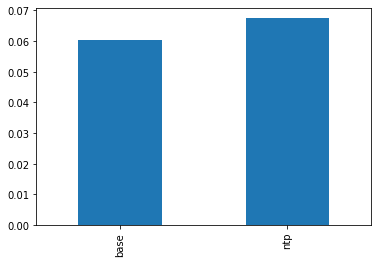

In [17]:
df.loc['biomass_dilution_s'].plot.bar()

<AxesSubplot:>

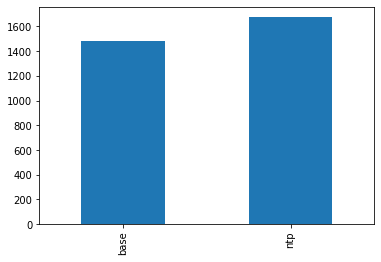

In [21]:
df.abs().gt(0).sum().plot.bar()

### Gene interdependence

In [602]:
with open("./sporeme_solution_v4_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [603]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [604]:
import pandas as pd
df = pd.read_csv('essentiality_raw_results_naive_FS_transport.csv',index_col=0).T
VG_df = pd.read_csv('essentiality_raw_results.csv',index_col=0).T

In [605]:
cutoff = 1e-16
translation = df[df['biomass_dilution']>cutoff][[i for i in df.columns if re.search('translation_.*_s',i)]].T
active_base = translation[translation['base']>cutoff].T.drop('base')
inactive_base = translation[translation['base']<=cutoff].T.drop('base')

In [606]:
essential_genes = list(df[df['biomass_dilution']<cutoff].index)
VG_essential_genes = list(VG_df[VG_df['biomass_dilution']<cutoff].index)
active_genes = [g.split('translation_')[1].split('_s')[0] for g in active_base.columns]

In [607]:
id_dep = defaultdict(list)
name_dep = defaultdict(list)
fwd_id_dep = defaultdict(list)
fwd_name_dep = defaultdict(list)
for g,row in active_base.iterrows():
    g = g.split('_s')[0]
    gname = locus_to_name[g]
    for i,_ in row[row<cutoff].items():
        gene = i.split('translation_')[1].split('_s')[0]
        gene_name = locus_to_name[gene]
        
        id_dep[gene].append(g)
        name_dep[gene_name].append(gname)
        
        fwd_id_dep[g].append(gene)
        fwd_name_dep[gname].append(gene_name)
        

### Known depletions

In [608]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

In [609]:
res = {}
for g in known_depletions:
    locus = name_to_locus[g]
    dep_genes = [i for i in id_dep[locus]]
    res[g] = {
        'locus_id':locus,
        'in_model':'RNA_'+locus in sporeme.metabolites,
        'FS_essential':locus in essential_genes,
        'VG_essential':locus in VG_essential_genes,
        'active':locus in active_genes,
        'depends on':', '.join([locus_to_name[i] if i in locus_to_name else i for i in dep_genes])
    }

In [610]:
res_df = pd.DataFrame.from_dict(res).T.sort_index()

In [37]:
res_df.to_csv('proteomics/dependence_results_transport.csv')

In [611]:
res_df.sort_values('depends on',ascending=False).head(20)

,locus_id,in_model,FS_essential,VG_essential,active,depends on
pabA,BSU00750,True,False,False,True,"trpF, trpD, trpC, trpB, trpA, ppaC, pabA, glnA"
sucD,BSU16100,True,False,False,True,"sucC, sucD, gpsA"
sucC,BSU16090,True,False,False,True,"sucC, sucD, gpsA"
purL,BSU06480,True,False,False,True,"qdoI, adk, serC, ldeG, era, cysP, pftB, serA, purC, purM, purB, purL, purF, purH, purD, glnA, purA, pyk, iolD, ansA, gbsA, hisG, unpK"
purC,BSU06450,True,False,False,True,"qdoI, adk, serC, ldeG, era, cysP, pftB, serA, purC, purM, purB, purF, purH, purD, glnA, purA, pyk, iolD, ansA, gbsA, hisG, unpK"
mdh,BSU29120,True,False,False,True,"pycA, era, fumC, nadE, mdh"
pyrAB,BSU15520,True,False,False,True,"pstA, sigV, pbuG, trpE, leuA, ilvC, pheA, pycA, gutP, akrN, adk, alrA, serC, gltT, mntC, nirC, hemB, pksG, atpD, ldeG, ackA, blt, ppaC, gabP, pyrG, aldY, era, araB, alsT, pta, glpT, phoA, sdhB, sirC, gudD, spoVFB, rpiB, mmgD, mmgE, narK, ilvA, serA, znuB, pyrK, pyrC, pyrD, pyrAA, pyrF, pyrB, pyrAB, pyrE, dhbC, cysK, ilvD, nadE, purQ, mrpF, scoB, scoA, gmuE, acoA, glgA, glgB, fadA, fadN, glnA, nasC, nasE, pbuX, xpt, katA, iolF, iolJ, lcfB, manP, amhX, galK, ureC, ureA, licC, pbuO, sigD, sigM, pgoN, opuCB, gndA, efeU, prs, brnQ, hemE, tcyL, opuBA, udk, yugH, yumB, fhuG, hisA, fabZ, ohaC, gmk, yojA, dutB, kduD"
pyrAA,BSU15510,True,False,False,True,"pstA, sigV, pbuG, trpE, leuA, ilvC, pheA, pycA, gutP, akrN, adk, alrA, serC, gltT, mntC, nirC, hemB, pksG, atpD, ldeG, ackA, blt, ppaC, gabP, pyrG, aldY, era, araB, alsT, pta, glpT, phoA, sdhB, sirC, gudD, spoVFB, rpiB, mmgD, mmgE, narK, ilvA, serA, znuB, pyrK, pyrC, pyrD, pyrAA, pyrF, pyrB, pyrAB, pyrE, dhbC, cysK, ilvD, nadE, purQ, mrpF, scoB, scoA, gmuE, acoA, glgA, glgB, fadA, fadN, glnA, nasC, nasE, pbuX, xpt, katA, iolF, iolJ, lcfB, manP, amhX, galK, ureC, ureA, licC, pbuO, sigD, sigM, pgoN, opuCB, gndA, efeU, prs, brnQ, hemE, tcyL, opuBA, udk, yugH, yumB, fhuG, hisA, fabZ, ohaC, gmk, yojA, dutB, kduD"
argG,BSU29450,True,False,False,True,"ppaC, nadE, argH, argG"
argH,BSU29440,True,False,False,True,"ppaC, nadE, argH, argG"


In [612]:
# None of them are essential
res_df['FS_essential'].value_counts()

False    89
Name: FS_essential, dtype: int64

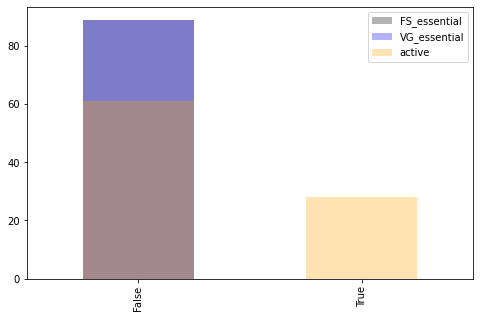

In [47]:
# None of them are essential
fig, ax = plt.subplots(figsize=(8,5))
res_df['FS_essential'].value_counts().plot.bar(ax=ax,color='k',alpha=0.3)
res_df['VG_essential'].value_counts().plot.bar(ax=ax,color='b',alpha=0.3)
res_df['active'].value_counts().plot.bar(ax=ax,color='orange',alpha=0.3)
plt.legend()
plt.savefig('./figures/gene_interdependence_stats_transport.svg',format='SVG')

In [48]:
res_df['active'].value_counts()

False    61
True     28
Name: active, dtype: int64

In [49]:
res_df[res_df['active']==True]

,locus_id,in_model,FS_essential,VG_essential,active,depends on
acdA,BSU37170,True,False,False,True,"acdA, fadA, fadN"
argB,BSU11210,True,False,False,True,"aroX, qdoI, gltB, sigV, aroA, trpD, ilvC, guaB, pheA, adk, serC, sigW, pncB, ldeG, penP, odhB, odhA, ppaC, era, araB, yqxL, nadA, glpQA, cysP, dapG, trpP, argD, argF, argJ, argC, carA, carB, argB, sucC, sucD, serA, dusB, pdhA, pdhB, pdhC, pdhD, pftA, pyrP, tuaG, tuaC, nadE, mrpD, mrpB, dgk, ilvK, glnA, feuC, xpt, aroC, katE, argI, sxzZ, opuE, tktA, nupC, licC, ansA, maeS, xylB, malP, pgm, glmU, glmM, gapB, buk, citB, yxeR, tcyM, icd, argH, argG, sufU, lysP, mdxE, hisD, hisG, ywrK, rpe, sdaAB, uppS, yppS, yojA, aroB, aroF, mleN, aroE, nadD"
argD,BSU11220,True,False,False,True,"aroX, qdoI, gltB, sigV, aroA, trpD, ilvC, guaB, pheA, adk, serC, sigW, pncB, ldeG, penP, odhB, odhA, ppaC, era, araB, yqxL, nadA, glpQA, cysP, dapG, trpP, argD, argF, argJ, argC, carA, carB, argB, sucC, sucD, serA, dusB, pdhA, pdhB, pdhC, pdhD, pftA, pyrP, tuaG, tuaC, nadE, mrpD, mrpB, dgk, ilvK, glnA, feuC, xpt, aroC, katE, argI, sxzZ, opuE, tktA, nupC, licC, ansA, maeS, xylB, malP, pgm, glmU, glmM, gapB, buk, citB, yxeR, tcyM, icd, argH, argG, sufU, lysP, mdxE, hisD, hisG, ywrK, rpe, sdaAB, uppS, yppS, yojA, aroB, aroF, mleN, aroE, nadD"
argF,BSU11250,True,False,False,True,"aroX, qdoI, gltB, sigV, aroA, trpD, ilvC, guaB, adk, serC, sigW, pncB, ldeG, penP, odhB, odhA, ppaC, era, yqxL, nadA, glpQA, cysP, dapG, trpP, argD, argF, argJ, argC, carA, carB, argB, sucC, sucD, serA, dusB, pdhA, pdhB, pdhC, pdhD, pftA, pyrP, tuaG, tuaC, nadE, mrpD, mrpB, dgk, ilvK, glnA, feuC, xpt, aroC, katE, argI, opuE, tktA, nupC, licC, ansA, maeS, xylB, malP, pgm, glmU, glmM, gapB, buk, citB, yxeR, tcyM, icd, argH, argG, sufU, lysP, mdxE, hisD, hisG, ywrK, rpe, sdaAB, uppS, yppS, yojA, aroB, aroF, mleN, aroE, nadD"
argG,BSU29450,True,False,False,True,"ppaC, nadE, argH, argG"
argH,BSU29440,True,False,False,True,"ppaC, nadE, argH, argG"
argJ,BSU11200,True,False,False,True,"aroX, qdoI, gltB, sigV, aroA, trpD, ilvC, guaB, pheA, adk, serC, sigW, pncB, ldeG, penP, odhB, odhA, ppaC, era, araB, yqxL, nadA, glpQA, cysP, dapG, trpP, argD, argF, argJ, argC, carA, carB, argB, sucC, sucD, serA, dusB, pdhA, pdhB, pdhC, pdhD, pftA, pyrP, tuaG, tuaC, nadE, mrpD, mrpB, dgk, ilvK, glnA, feuC, xpt, aroC, katE, argI, sxzZ, opuE, tktA, nupC, licC, ansA, maeS, xylB, malP, pgm, glmU, glmM, gapB, buk, citB, yxeR, tcyM, icd, argH, argG, sufU, lysP, mdxE, hisD, hisG, ywrK, rpe, sdaAB, uppS, yppS, yojA, aroB, aroF, mleN, aroE, nadD"
carB,BSU11240,True,False,False,True,"ctaA, aroX, qdoI, msrB, pdxS, gltB, sigH, rbsD, menF, pdxK, aroA, trpF, trpD, trpC, mgtE, leuC, ilvC, mtnN, maeN, mccA, mccB, guaB, qoxB, pgl, ytrD, ytrE, pheA, qcrA, arsF, rhgP, serC, sigW, mntA, yodF, hemC, hemD, proB, atpI, atpF, atpC, natA, pncB, tcyP, sacP, ldeG, ldeE, ldeJ, ldeI, penP, odhB, odhA, apt, ppaC, dsdA, ssuD, era, yqxL, fumC, nadA, bioB, sigP, glpQA, cysP, dapG, kdgD, trpP, lctP, bglP, argD, argF, argJ, argC, proI, carA, carB, argB, copA, iolS, dppC, mntH, sucC, sucD, serA, cwlC, samT, lutP, pabC, dusB, pdhA, pdhB, pdhC, pdhD, pftA, pyrP, treP, tuaG, tuaH, tuaC, ctaE, ctaD, folEA, purC, nadE, purE, ndh, mrpD, mrpB, gmuC, opuAA, dgk, chaA, ycsA, ilvK, glnQ, glnM, glpF, glgP, glnA, mtlD, purA, feuC, glmS, aroC, sigF, katE, pbtP, pbtQ, iolD, argI, opuE, tktA, nupC, ureB, licC, licH, cwlD, pupG, deoB, thiE, hisK, ansA, maeS, ribBA, speE, xylB, tadA, thrD, malP, pgm, aldX, glmU, ptsI, lytD, pckA, glmM, hemH, nupG, gapB, buk, citB, yxeR, tcyM, tcyN, icd, argH, argG, ytcB, gbsA, ktrB, mrpA, sufU, yvrC, lysP, mdxM, mdxE, trxB, hisB, hisD, hisG, ywrK, chrA, tdk, clsB, queD, glsB, suhB, coaD, thiQ, rpe, sdaAB, sdaAA, pyrH, uppS, yppS, yodQ, mtbP, panB, aroB, aroF, gpsA, lysA, mleN, unpK, aroE, yraO, nadD"
citB,BSU18000,True,False,False,True,"citB, icd, sufU"
fadN,BSU32840,True,False,False,True,"fadA, fadN"


In [52]:
res_df.loc[confirmed_depletions]

,locus_id,in_model,FS_essential,VG_essential,active,depends on
pckA,BSU30560,True,False,False,False,
purL,BSU06480,True,False,False,True,"qdoI, adk, serC, ldeG, era, cysP, pftB, serA, purC, purM, purB, purL, purF, purH, purD, glnA, purA, pyk, iolD, ansA, gbsA, hisG, unpK"
ilvB,BSU28310,True,False,False,True,"ilvB, ilvC, ilvH, ilvD, sufU"
ilvE,BSU02390,True,False,False,False,
citZ,BSU29140,True,False,False,False,
acsA,BSU29680,True,False,False,False,
etfA,BSU28520,False,False,False,False,
acoC,BSU08080,False,False,False,False,
sigF,BSU23450,True,False,False,False,
yxbC,BSU39880,False,False,False,False,


13


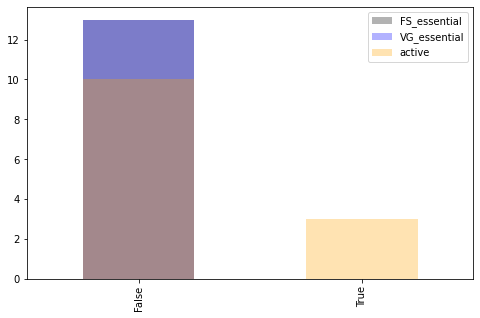

In [45]:
print(len(confirmed_depletions))
# None of them are essential
fig, ax = plt.subplots(figsize=(8,5))
res_df.loc[confirmed_depletions]['FS_essential'].value_counts().plot.bar(ax=ax,color='k',alpha=0.3)
res_df.loc[confirmed_depletions]['VG_essential'].value_counts().plot.bar(ax=ax,color='b',alpha=0.3)
res_df.loc[confirmed_depletions]['active'].value_counts().plot.bar(ax=ax,color='orange',alpha=0.3)
plt.legend()
plt.savefig('./figures/confirmed_gene_interdependence_stats_transport.svg',format='SVG')

In [52]:
df = res_df.loc[confirmed_depletions]
df[df['in_model']==False].shape[0]

5

In [53]:
res_df[res_df['in_model']==False].shape[0]

30

In [629]:
res_df.shape

(89, 6)

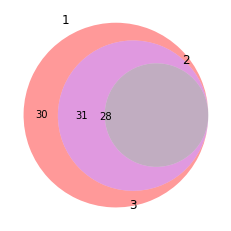

In [634]:
from matplotlib_venn import venn2,venn3
df = res_df
plt.rcParams['svg.fonttype'] = 'none'
df1 = set(df[df['FS_essential']==False].index)
df2 = set(df[df['active']==True].index)
df3 = set(df[df['in_model']==True].index)
venn3([df1,df2,df3],('1','2','3'))
plt.savefig('./figures/venn_essential_active_model_known.svg',format='SVG')

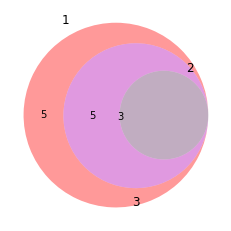

In [635]:
from matplotlib_venn import venn2,venn3
df = res_df.loc[confirmed_depletions]
plt.rcParams['svg.fonttype'] = 'none'
df1 = set(df[df['FS_essential']==False].index)
df2 = set(df[df['active']==True].index)
df3 = set(df[df['in_model']==True].index)
venn3([df1,df2,df3],('1','2','3'))
plt.savefig('./figures/venn_essential_active_model_confirmed.svg',format='SVG')

## Backward interdependence

In [81]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(j,i)

In [82]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

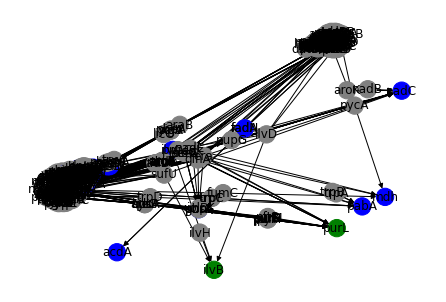

In [84]:
# plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
#        pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_transport.svg',format='SVG')

## Forward interdependence

In [589]:
fwd_name_dep['pyrAA']

['pyrAA', 'pyrAB']

In [85]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [86]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

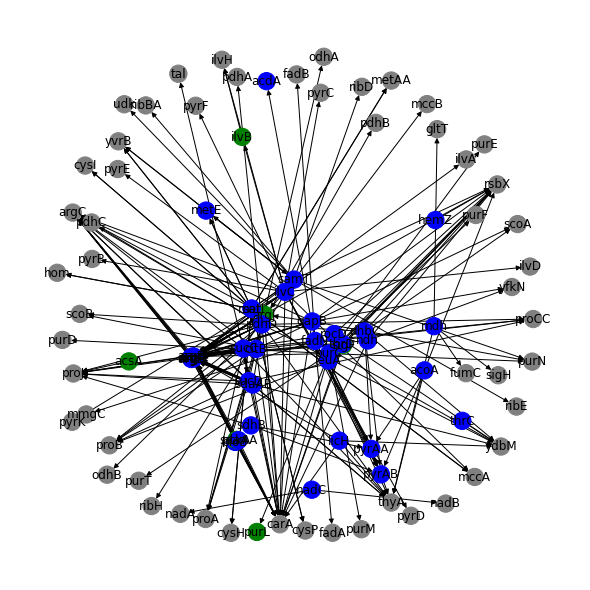

In [59]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
#        pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_transport.svg',format='SVG')

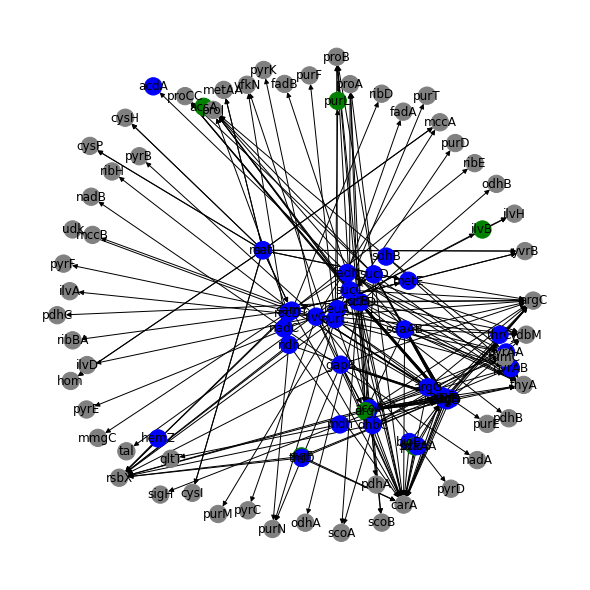

In [87]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
#        pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_transport.svg',format='SVG')

## FWD and BWD interdependence

In [301]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(j,i)

for i in res_df[res_df['in_model']==True].index:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [302]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

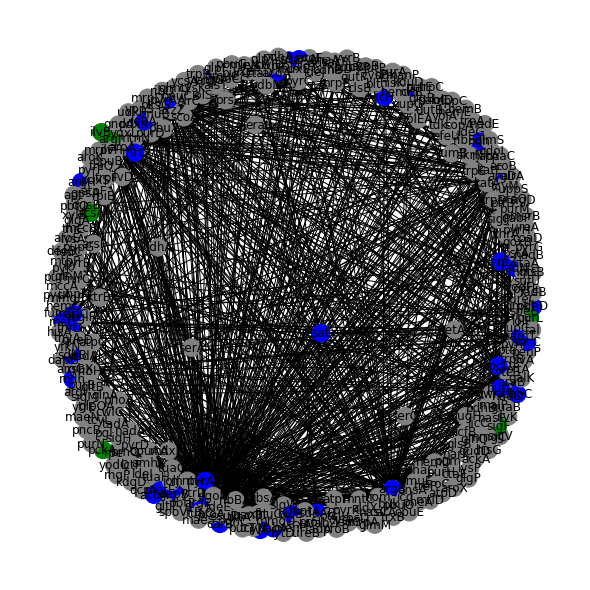

In [303]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map)
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_bwd.svg',format='SVG')

## Genome-scale interdependence

In [531]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in sporeme.genes:
    i = i.id
    dep_genes = fwd_id_dep[i]
#     if len(dep_genes) < 30: continue
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)
print(len(G.edges))

2824


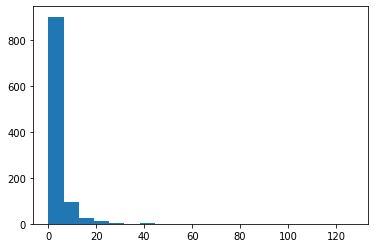

In [532]:
_=plt.hist([len(fwd_id_dep[i]) for i in fwd_id_dep],bins=20)

In [114]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_id_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
    if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node

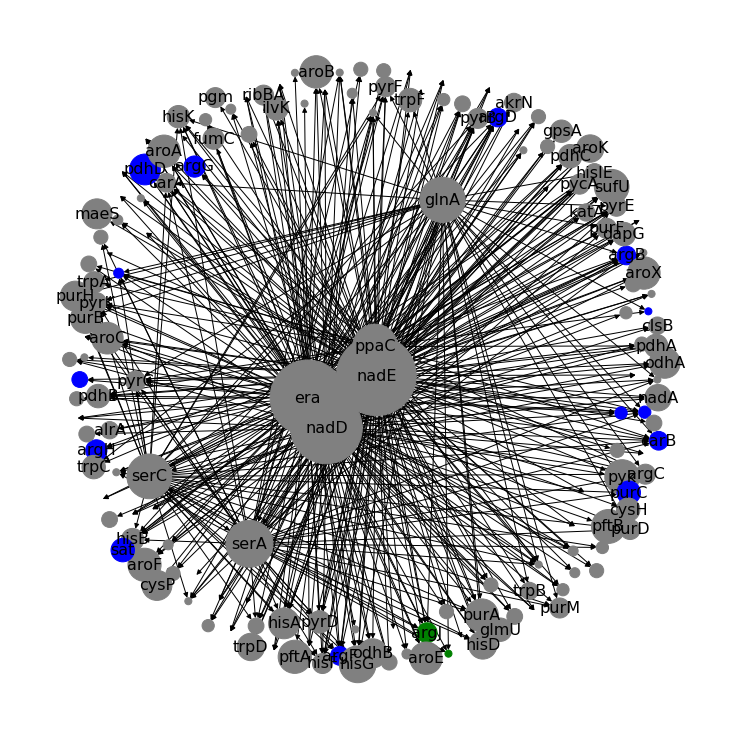

In [116]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

## One gene interdependence

In [469]:
def get_value(k):
    return list(set(fwd_name_dep[k]) - set([k]))

def traverse_graph(k,seen = set()):
    v = get_value(k)
#     print(k,v)
    if not v:
        return seen
    for i in v:
        if i in seen:continue
        seen.add(i)
        seen = traverse_graph(i,seen=seen)
    return seen

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    seen_nodes = set()
    for i in traverse_graph(gene):
        if i in seen_nodes: continue
        seen_nodes.add(i)
        dep_genes = fwd_name_dep[i]
        for j in dep_genes:
            if j==i: continue
            G.add_edge(i,j)
    return G

In [567]:
gene = 'ilvB'
G = get_graph_from_gene(gene)
G.nodes

NodeView(('ilvH', 'proJ', 'ilvB', 'argC', 'argJ', 'argB', 'argD', 'carA', 'carB', 'argF', 'rsbX'))

In [568]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

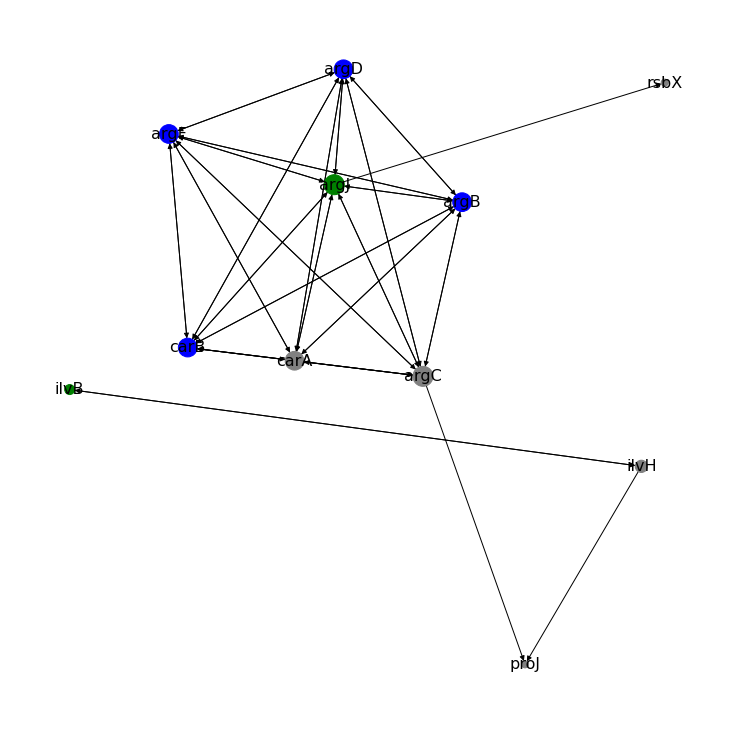

In [569]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
plt.savefig('./figures/network_gene_interdependence_spring_fwd_{}.svg'.format(gene),format='SVG')

## Known depletions neighborhood

In [590]:
def get_value(k):
    return list(set(fwd_name_dep[k]) - set([k]))

def traverse_graph(k,seen = set()):
    v = get_value(k)
#     print(k,v)
    if not v:
        return seen
    for i in v:
        if i in seen:continue
        seen.add(i)
        seen = traverse_graph(i,seen=seen)
    return seen

In [591]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()
seen_nodes = set()
for j in known_depletions:
    for i in traverse_graph(j):
        if i in seen_nodes: continue
#         if not fwd_name_dep[i]: continue
        seen_nodes.add(i)
        dep_genes = fwd_name_dep[i]
        for k in dep_genes:
            if k==j: continue
            G.add_edge(i,j)

In [592]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

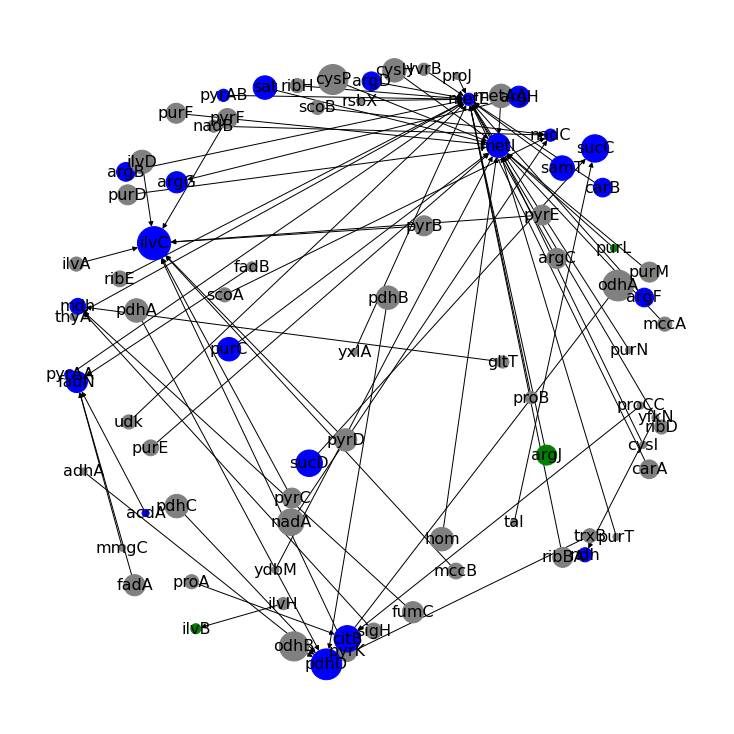

In [593]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=1.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

In [596]:
G.nodes

NodeView(('ribH', 'metE', 'argD', 'rsbX', 'purN', 'pyrAA', 'carB', 'carA', 'ribD', 'proB', 'yvrB', 'argF', 'ribE', 'samT', 'yxlA', 'argJ', 'udk', 'proJ', 'pyrAB', 'argC', 'argB', 'ribBA', 'thyA', 'purL', 'metI', 'purM', 'ydbM', 'cysP', 'purE', 'metAA', 'mccA', 'purT', 'cysI', 'purD', 'hom', 'sat', 'purF', 'cysH', 'purC', 'ilvB', 'ilvH', 'nadC', 'scoA', 'nadA', 'nadB', 'scoB', 'pyrB', 'ilvC', 'pyrD', 'pyrK', 'ilvA', 'pyrF', 'pyrC', 'mccB', 'ilvD', 'pyrE', 'proCC', 'citB', 'proA', 'sucC', 'tal', 'sucD', 'yfkN', 'ndh', 'sigH', 'mdh', 'gltT', 'fumC', 'fadB', 'fadN', 'fadA', 'acdA', 'mmgC', 'adhA', 'pdhD', 'odhB', 'pdhC', 'pdhB', 'pdhA', 'odhA', 'trxB', 'argG', 'argH'))

In [595]:
len(G.nodes)

83

In [597]:
pd.DataFrame.from_dict({'locus':{i:name_to_locus[i] for i in G.nodes}}).to_csv('confirmed_depletion_neighborhood.txt',header=None)

In [598]:
set(G.nodes) & set(confirmed_depletions)

{'argJ', 'ilvB', 'purL'}

In [599]:
set(name_dep['yxlA'])

{'akrN', 'atpC', 'hisA', 'sigP', 'udk', 'yxlA'}

In [600]:
set(name_dep['samT']) & set(known_depletions)

{'metE', 'metI', 'samT', 'sat'}

In [601]:
set(name_dep['samT']) & set(confirmed_depletions)

set()

## Confirmed depletions neighborhood

In [574]:
def get_value(k):
    return list(set(fwd_name_dep[k]) - set([k]))

def traverse_graph(k,seen = set()):
    v = get_value(k)
#     print(k,v)
    if not v:
        return seen
    for i in v:
        if i in seen:continue
        seen.add(i)
        seen = traverse_graph(i,seen=seen)
    return seen

In [575]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()
seen_nodes = set()
for j in confirmed_depletions:
    for i in traverse_graph(j):
        if i in seen_nodes: continue
#         if not fwd_name_dep[i]: continue
        seen_nodes.add(i)
        dep_genes = fwd_name_dep[i]
        for j in dep_genes:
            if j==i: continue
            G.add_edge(i,j)

In [576]:
confirmed_depletions

['pckA',
 'purL',
 'ilvB',
 'ilvE',
 'citZ',
 'acsA',
 'etfA',
 'acoC',
 'sigF',
 'yxbC',
 'lutC',
 'argJ',
 'hpf']

In [577]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

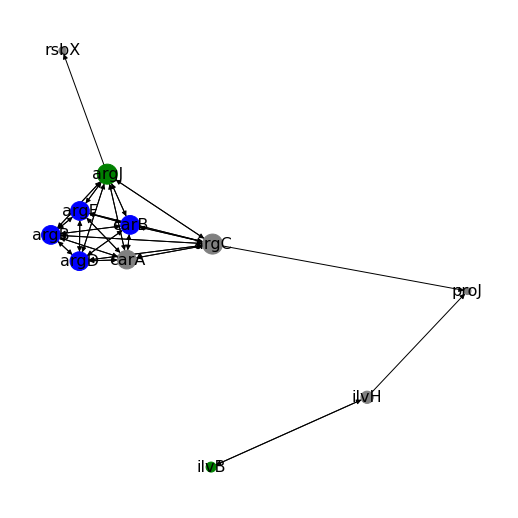

In [578]:
plt.figure(figsize=(7,7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree]
       )
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

## Histogram

In [309]:
d = {k:len(v) for k,v in fwd_name_dep.items()}

,influence
acdA,1
ackA,4
acoA,4
acoB,0
acsA,1
...,...
yvrC,5
ywrK,8
yxeR,10
yxlA,1


In [313]:
df = pd.DataFrame.from_dict({'influence':d})

<AxesSubplot:ylabel='Frequency'>

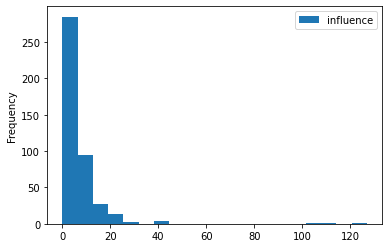

In [314]:
df.plot.hist(bins = 20)

In [327]:
df.loc[[i for i in confirmed_depletions if i in df.index]]

,influence
pckA,2
purL,1
ilvB,2
ilvE,0
citZ,0
acsA,1
sigF,3
argJ,8


## Heatmap

In [117]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [118]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]

In [386]:
import pandas as pd
df = pd.read_csv('essentiality_raw_results_naive_FS_transport.csv',index_col=0).T
translation = df[[i for i in df.columns if re.search('translation_.*_s',i)]].T
translation = translation[translation['base']>cutoff].T

In [192]:
from tqdm import tqdm
import seaborn as sns
from scipy.stats import zscore

In [170]:
expression = {}
for i,row in tqdm(translation.iterrows(),total=translation.shape[0]):
    i = i.split('_s')[0]
    iname = locus_to_name[i] if i in locus_to_name else i
    expression[iname] = {}
    for j,val in row.items():
        j = j.split('translation_')[1].split('_s')[0]
        jname = locus_to_name[j] if j in locus_to_name else j
        expression[iname][jname] = val
expression = pd.DataFrame.from_dict(expression).drop('dummy')

100%|██████████| 965/965 [00:00<00:00, 1056.87it/s]


In [186]:
depletions_in_model = [i for i in known_depletions if i in expression.index]

In [188]:
log_expression_all = np.log10(expression[depletions_in_model + ['base']]+1e-16)
log_expression_known = np.log10(expression.loc[depletions_in_model][depletions_in_model + ['base']]+1e-16)

<AxesSubplot:>

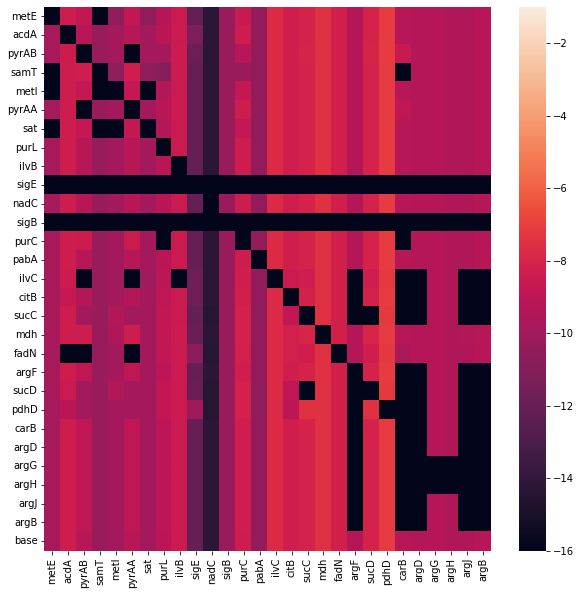

In [210]:
plt.figure(figsize=(10,10))
sns.heatmap(log_expression_known.T,
           vmin = -1,
           vmax = -16)

<AxesSubplot:>

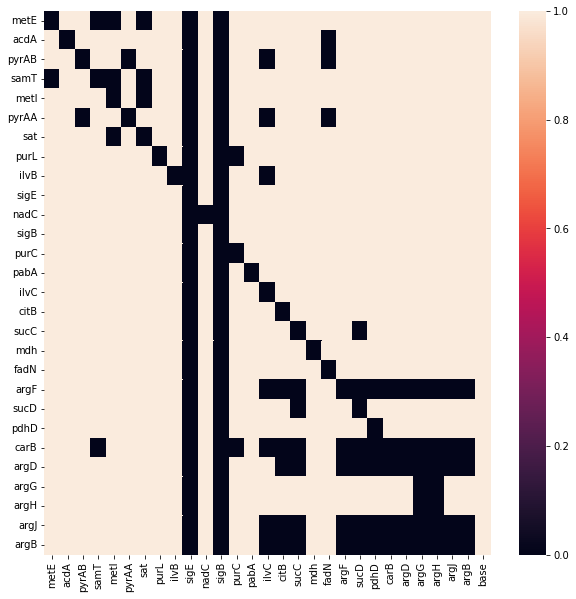

In [218]:
plt.figure(figsize=(10,10))
sns.heatmap((expression>0.).loc[depletions_in_model][depletions_in_model + ['base']])

/home/jt/me_modeling/lib/python3.6/site-packages/seaborn/matrix.py:654 UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 1440x720 with 0 Axes>

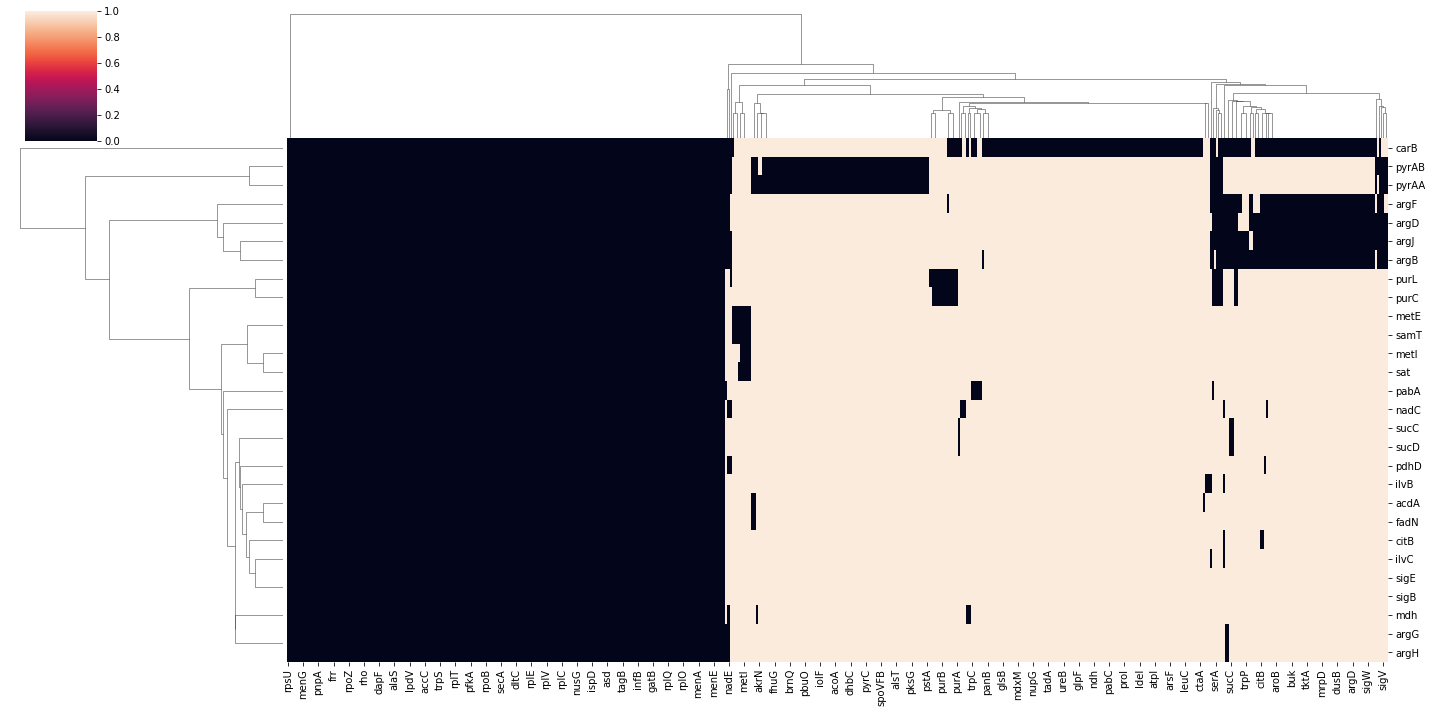

In [297]:
df = expression.loc[depletions_in_model]
induced_inactivation_of_known = df.T.loc[(df==0).any()].T
plt.figure(figsize=(20,10))
sns.clustermap(induced_inactivation_of_known>0,
              figsize=(20,10))

/home/jt/me_modeling/lib/python3.6/site-packages/seaborn/matrix.py:654 UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 1440x720 with 0 Axes>

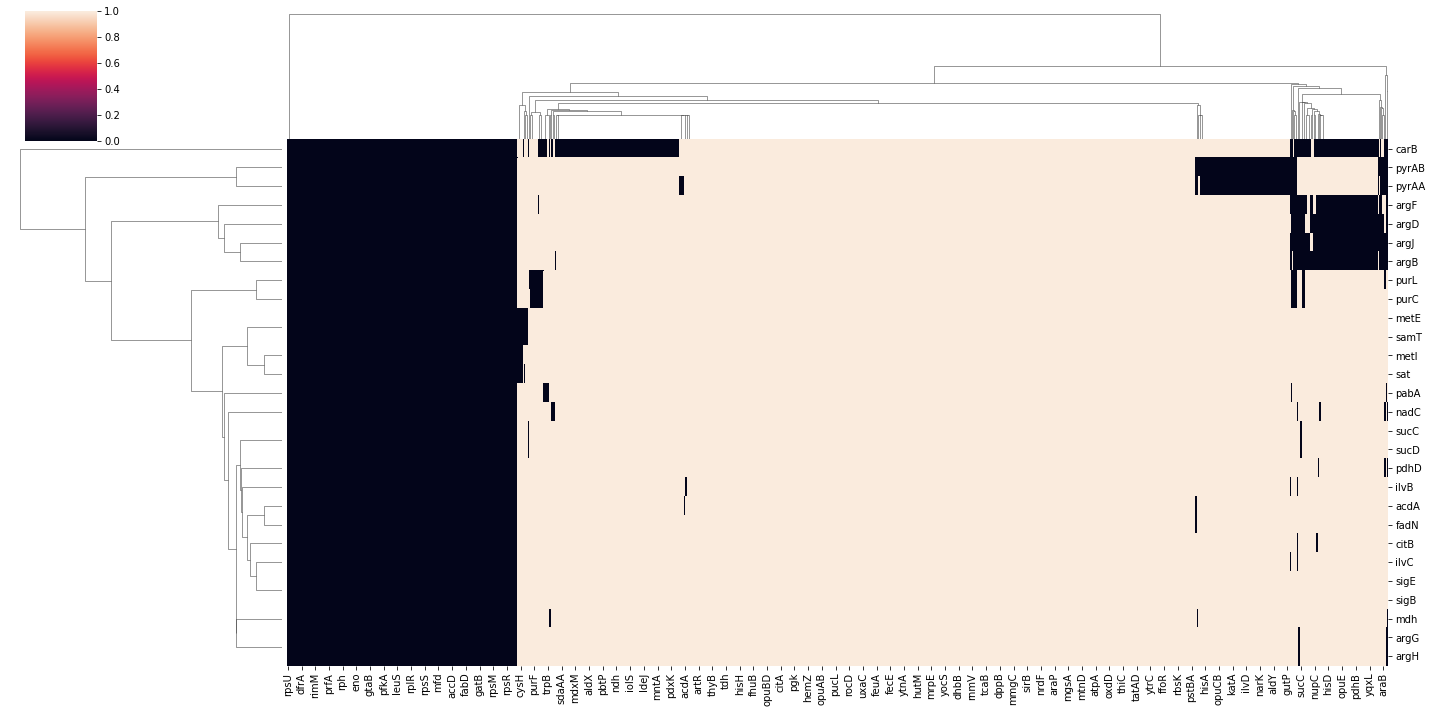

In [299]:
df = expression.loc[depletions_in_model].T
inactivated_by_known = df.T.loc[(df==0).any()].T
plt.figure(figsize=(20,10))
sns.clustermap(inactivated_by_known.T>0,
              figsize=(20,10))

<AxesSubplot:>

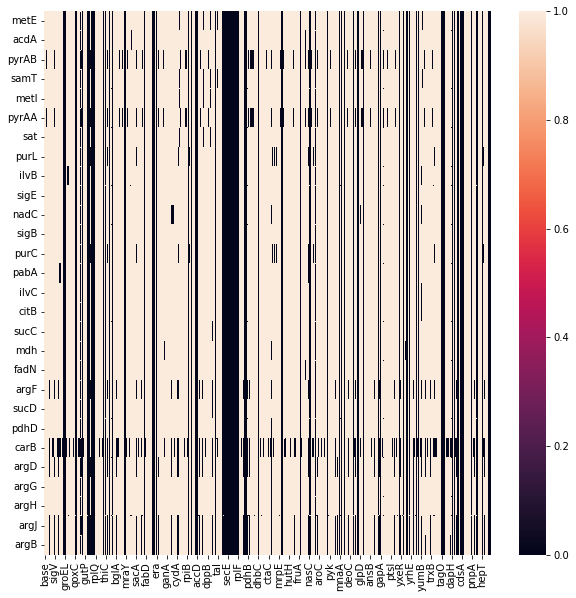

In [247]:
plt.figure(figsize=(10,10))
sns.heatmap((expression>0.)[depletions_in_model])

<AxesSubplot:>

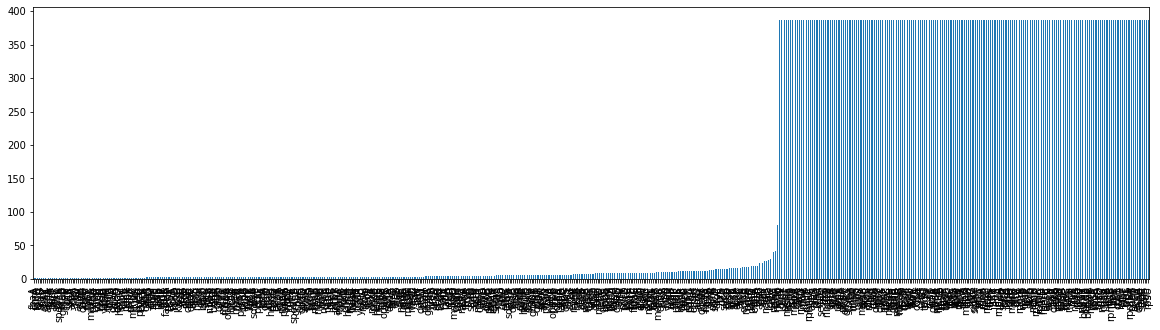

In [234]:
plt.figure(figsize=(20,5))
df = (expression==0.).sum()
df[df>0].sort_values().plot.bar()

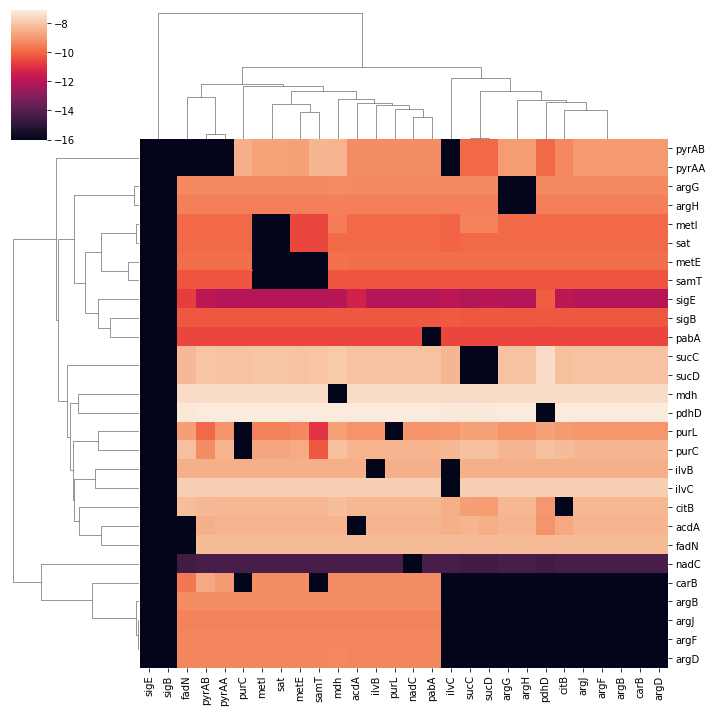

In [140]:
sns.clustermap(log_expression_known,
              figsize=(10,10))

/home/jt/me_modeling/lib/python3.6/site-packages/seaborn/matrix.py:654 UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


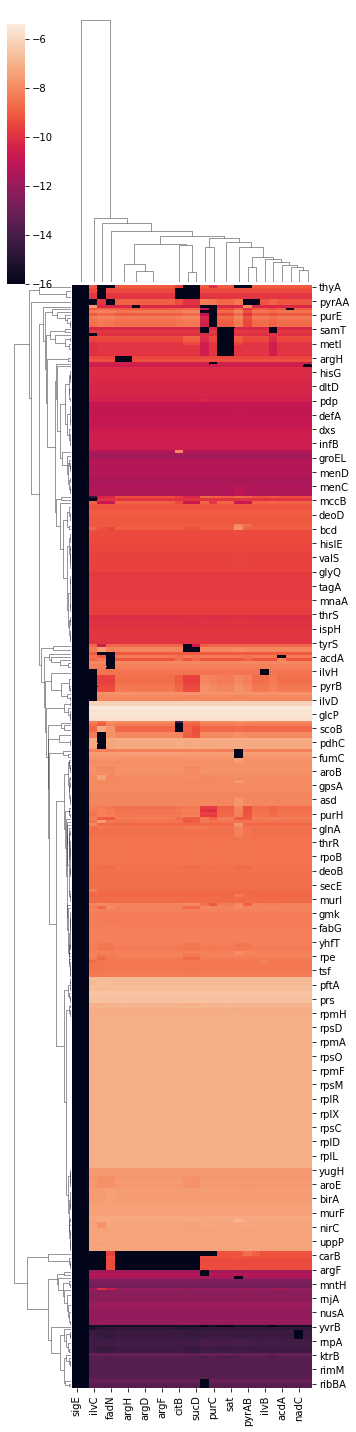

In [141]:
sns.clustermap(log_expression_all,
              figsize=(5,20))